# Torch

In [ ]:
!pip3 install 'torch'
!pip3 install 'torchvision'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
!pip3 install "colorama"

import torch
#use GPU if available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #'cpu' # 'cuda' or 'cpu'
print(DEVICE)

# Download Dataset GTEA61

In [ ]:
from google.colab import drive
import os
#drive.mount('/content/drive')
import sys, os

#1YKfdhB9Xxh4pmND1V3gcm3Gyjc8v8idq
if not os.path.isfile('/content/GTEA61.zip'):
  !gdown --id 1Z5RWA8yKIy0PvxMlScV-aAz22ITtivfk # 3-5 min
  !jar xvf  "/content/GTEA61.zip"

if not os.path.isdir('/content/GTEA61'):
  print("Dataset doesn't exist")

#Weights
if not os.path.isfile("/content/best_model_state_dict_rgb_split2.pth"):
  !gdown --id 1B7Xh6hQ9Py8fmL-pjmLzlCent6dnuex5 # 3-5 min



# Download Code

In [ ]:
!git clone "https://github.com/peteralhachem/advanced-machine-learning.git"



# Import Code


In [22]:
import os
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.backends import cudnn
import torchvision
from colorama import init
from colorama import Fore, Back, Style
from itertools import chain

from torchvision.models import resnet34
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np


from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')



In [5]:
import sys
sys.path.append("/content/advanced-machine-learning/RNN/RNN_utils")
os.chdir("/content/advanced-machine-learning/RNN/RNN_utils")




In [6]:
# import from RNN_utils
from gtea_dataset import GTEA61, GTEA61_flow, GTEA61_2Stream
from spatial_transforms import (Compose, ToTensor, CenterCrop, Scale, Normalize, MultiScaleCornerCrop,
                                RandomHorizontalFlip)

#Setting up parameters

In [7]:
#homework_step = 0 #--> Learning without Temporal information (avgpool)
#homework_step = 1 #--> Learning with Temporal information (LSTM)
homework_step = 2 #--> Learning with Spatio-Temporal information (ConvLSTM)


DATA_DIR = '/content/GTEA61/' #path dataset
model_folder = '/content/saved_models/' + "/" + "homework_step"+ str(homework_step) + "/" #path to save model
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)

# Hyperparameter Optimization

hyperparameters = {'LR': [0.01, 0.001, 1e-4], 'BATCH_SIZE': [16, 32, 64], 'WEIGHT_DECAY': [1e-5, 1e-4, 1e-3] }

# All this param can be change!

NUM_CLASSES = 61
BATCH_SIZE = 32
LR = 0.001            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 100     # Total number of training epochs (iterations over dataset)
STEP_SIZE = [50]        # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
MEM_SIZE = 512       # Dim of internal state of LSTM or ConvLSTM
SEQ_LEN = 3          # Num Frames

# this dictionary is needed for the logger class
parameters = {'DEVICE':DEVICE, 'NUM_CLASSES':NUM_CLASSES, 'BATCH_SIZE':BATCH_SIZE,
             'LR':LR, 'MOMENTUM':MOMENTUM, 'WEIGHT_DECAY':WEIGHT_DECAY, 'NUM_EPOCHS':NUM_EPOCHS,
             'STEP_SIZE':STEP_SIZE, 'GAMMA':GAMMA, 'MEM_SIZE':MEM_SIZE, 'SEQ_LEN':SEQ_LEN}

#Dataloaders & Preprocessing

In [8]:
# Normalize
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
spatial_transform = Compose([Scale(256), RandomHorizontalFlip(), MultiScaleCornerCrop([1, 0.875, 0.75, 0.65625], 224),
                             ToTensor(), normalize])
spatial_transform_val = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])


In [9]:
# Prepare Pytorch train/test Datasets
train_dataset = GTEA61(DATA_DIR, split='train', transform=spatial_transform, seq_len=SEQ_LEN)
test_dataset = GTEA61(DATA_DIR, split='test', transform=spatial_transform_val, seq_len=SEQ_LEN)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


['S1', 'S4', 'S3', 'S2']
['S1', 'S4', 'S3', 'S2']
Train Dataset: 341
Test Dataset: 116


#Model

In [10]:
import torch
import resnetMod
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import numpy as np
import cv2



# LSTM
class MyLSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(MyLSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.conv_i_xx = nn.Linear(input_size, hidden_size)
        self.conv_i_hh = nn.Linear(hidden_size, hidden_size, bias=False)


        self.conv_f_xx = nn.Linear(input_size, hidden_size)
        self.conv_f_hh = nn.Linear(hidden_size, hidden_size, bias=False)

        self.conv_c_xx = nn.Linear(input_size, hidden_size)
        self.conv_c_hh = nn.Linear(hidden_size, hidden_size, bias=False)

        self.conv_o_xx = nn.Linear(input_size, hidden_size)
        self.conv_o_hh = nn.Linear(hidden_size, hidden_size, bias=False)

        torch.nn.init.xavier_normal_(self.conv_i_xx.weight)
        torch.nn.init.constant_(self.conv_i_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_i_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_f_xx.weight)
        torch.nn.init.constant_(self.conv_f_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_f_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_c_xx.weight)
        torch.nn.init.constant_(self.conv_c_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_c_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_o_xx.weight)
        torch.nn.init.constant_(self.conv_o_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_o_hh.weight)

        #fully connected layer
        self.fc = nn.Linear(hidden_size, 512)
        torch.nn.init.xavier_normal_(self.fc.weight)
        torch.nn.init.constant_(self.fc.bias, 0)




    def forward(self, x, state):
        if state is None:
            state = (Variable(torch.randn(x.size(0), x.size(1)).cuda()),
                     Variable(torch.randn(x.size(0), x.size(1)).cuda()))

        ht_1, ct_1 = state
        it = torch.sigmoid(self.conv_i_xx(x) + self.conv_i_hh(ht_1))
        ft = torch.sigmoid(self.conv_f_xx(x) + self.conv_f_hh(ht_1))
        ct_tilde = torch.tanh(self.conv_c_xx(x) + self.conv_c_hh(ht_1))
        ct = (ct_tilde * it) + (ct_1 * ft)
        ot = torch.sigmoid(self.conv_o_xx(x) + self.conv_o_hh(ht_1))
        ht = ot * torch.tanh(ct)
        return ht, ct


#ConvLSTM
class MyConvLSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, kernel_size=3, stride=1, padding=1):
        super(MyConvLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Instead of using Linear relationship between the hidden and the input, we use a 2D-convolutional layer

        self.conv_i_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_i_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        self.conv_f_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_f_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        self.conv_c_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_c_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        self.conv_o_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_o_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        torch.nn.init.xavier_normal_(self.conv_i_xx.weight)
        torch.nn.init.constant_(self.conv_i_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_i_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_f_xx.weight)
        torch.nn.init.constant_(self.conv_f_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_f_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_c_xx.weight)
        torch.nn.init.constant_(self.conv_c_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_c_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_o_xx.weight)
        torch.nn.init.constant_(self.conv_o_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_o_hh.weight)


    def forward(self, x, state):
        if state is None:
            state = (Variable(torch.randn(x.size(0), x.size(1), x.size(2), x.size(3)).cuda()),
                     Variable(torch.randn(x.size(0), x.size(1), x.size(2), x.size(3)).cuda()))

        ht_1, ct_1 = state
        it = torch.sigmoid(self.conv_i_xx(x) + self.conv_i_hh(ht_1))
        ft = torch.sigmoid(self.conv_f_xx(x) + self.conv_f_hh(ht_1))
        ct_tilde = torch.tanh(self.conv_c_xx(x) + self.conv_c_hh(ht_1))
        ct = (ct_tilde * it) + (ct_1 * ft)
        ot = torch.sigmoid(self.conv_o_xx(x) + self.conv_o_hh(ht_1))
        ht = ot * torch.tanh(ct)
        return ht, ct


#Network
class ourModel(nn.Module):
    def __init__(self, num_classes=61, mem_size=512, homework_step = 0 , DEVICE=""):
        super(ourModel, self).__init__()
        self.DEVICE = DEVICE
        self.num_classes = num_classes
        self.resNet = resnetMod.resnet34(True, True)
        self.mem_size = mem_size
        self.weight_softmax = self.resNet.fc.weight
        self.homework_step = homework_step
        if self.homework_step == 1:
          self.lstm_cell = MyLSTMCell(512, mem_size)
        elif self.homework_step == 2:
          self.lstm_cell = MyConvLSTMCell(512, mem_size)

        self.avgpool = nn.AvgPool2d(7)
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(mem_size, self.num_classes)
        self.classifier = nn.Sequential(self.dropout, self.fc)


    def forward(self, inputVariable):
        #Learning without Temporal information (mean)
        if self.homework_step == 0:
            video_level_features = torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE)
            for t in range(inputVariable.size(0)):
                #spatial_frame_feat: (batch_size, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                #frames_feat: (batch_size, 512)
                frame_feat = self.avgpool(spatial_frame_feat).view(spatial_frame_feat.size(0), -1)
                video_level_features = video_level_features + frame_feat

            video_level_features = video_level_features / inputVariable.size(0)
            logits = self.classifier(video_level_features)

            return logits, video_level_features

        #Learning with Temporal information (LSTM)
        elif self.homework_step == 1:
            state = ( torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE),
                     torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE) )
            for t in range(inputVariable.size(0)):
                #spatial_frame_feat: (batch_size, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                #frames_feat: (batch_size, 512)
                frame_feat = self.avgpool(spatial_frame_feat).view(state[1].size(0), -1)
                state = self.lstm_cell(frame_feat, state)

            video_level_features = state[1]
            logits = self.classifier(video_level_features)

            return logits, video_level_features

        #Learning with Temporal information (ConvLSTM)
        elif self.homework_step == 2:
            state = (torch.zeros((inputVariable.size(1), self.mem_size, 7, 7)).to(self.DEVICE),
                     torch.zeros((inputVariable.size(1), self.mem_size, 7, 7)).to(self.DEVICE))
            for t in range(inputVariable.size(0)):
                #spatial_frame_feat: (batch_size, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                state = self.lstm_cell(spatial_frame_feat, state)
            video_level_features = self.avgpool(state[1]).view(state[1].size(0), -1)
            logits = self.classifier(video_level_features)

            return logits, video_level_features





#Build Model - Loss - Opt

In [ ]:
#CUDA_LAUNCH_BLOCKING=1
validate = True

model = ourModel(num_classes=NUM_CLASSES, mem_size=MEM_SIZE, homework_step=homework_step, DEVICE=DEVICE) #model

#Train only the lstm cell and classifier
model.train(True)
for params in model.parameters():
    params.requires_grad = False

if homework_step > 0:
    for params in model.lstm_cell.parameters():
        params.requires_grad = True
    model.lstm_cell.train(True)

for params in model.classifier.parameters():
    params.requires_grad = True
model.classifier.train(True)


model = model.to(DEVICE)

# run only when homework_step == 2
model.load_state_dict(torch.load("/content/best_model_state_dict_rgb_split2.pth", map_location=torch.device('cpu')), strict=True)


#Loss
loss_fn = nn.CrossEntropyLoss()
#Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
#Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)


# Hyperparameter Optimization (Do not run for Training)

---



In [ ]:
### Performing hyperparameter optimization

train_losses = {'LR': {}, 'BATCH_SIZE': {}, 'WEIGHT_DECAY': {}}
val_losses = { 'LR': {}, 'BATCH_SIZE': {}, 'WEIGHT_DECAY': {}}

for lr in hyperparameters['LR']:

  train_losses['LR'][lr] = []
  val_losses['LR'][lr] = []

  #Initialize Learning rate
  LR = lr
  optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
  #Scheduler
  optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

  train_iter = 0
  val_iter = 0
  min_accuracy = 0

  trainSamples = len(train_dataset) - (len(train_dataset) % BATCH_SIZE)
  val_samples = len(test_dataset)
  iterPerEpoch = len(train_loader)
  val_steps = len(val_loader)
  cudnn.benchmark
  model_checkpoint = "model" #name


  for epoch in range(NUM_EPOCHS):
      epoch_loss = 0
      numCorrTrain = 0

      model.classifier.train(True)

      for i, (inputs, targets) in enumerate(train_loader):
          train_iter += 1
          optimizer_fn.zero_grad()

          # (BS, Frames, C, W, H) --> (Frames, BS, C, W, H)
          inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
          labelVariable = targets.to(DEVICE)

          # feeds in model
          output_label, _ = model(inputVariable)

          # compute loss
          loss = loss_fn(output_label, labelVariable)

          # backward loss and optimizer step
          loss.backward()
          optimizer_fn.step()

          #compute the training accuracy
          _, predicted = torch.max(output_label.data, 1)
          numCorrTrain += torch.sum(predicted == labelVariable.data).data.item()
          step_loss = loss.data.item()
          epoch_loss += step_loss

      avg_loss = epoch_loss/iterPerEpoch
      trainAccuracy = (numCorrTrain / trainSamples) * 100

      train_losses['LR'][lr].append(avg_loss)

      print(Fore.BLACK + 'Train: Epoch = {} | Loss = {:.3f} | Accuracy = {:.3f}'.format(epoch+1, avg_loss, trainAccuracy))

      if validate:
        if (epoch+1) % 1 == 0:
            model.train(False)
            val_loss_epoch = 0
            numCorr = 0
            for j, (inputs, targets) in enumerate(val_loader):
                val_iter += 1
                inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
                labelVariable = targets.to(DEVICE)

                 # feeds in model
                output_label, _ = model(inputVariable)
                val_loss = loss_fn(output_label, labelVariable)
                val_loss_step = val_loss.data.item()
                val_loss_epoch += val_loss_step
                _, predicted = torch.max(output_label.data, 1)
                numCorr += torch.sum(predicted == labelVariable.data).data.item()

            val_accuracy = (numCorr / val_samples) * 100
            avg_val_loss = val_loss_epoch / val_steps

            val_losses['LR'][lr].append(avg_val_loss)

            print(Fore.GREEN + 'Val: Epoch = {} | Loss {:.3f} | Accuracy = {:.3f}'.format(epoch + 1, avg_val_loss, val_accuracy))
            if val_accuracy > min_accuracy:
                print("[||| NEW BEST on val||||]")
                save_path_model = os.path.join(model_folder, model_checkpoint)
                torch.save(model.state_dict(), save_path_model)
                min_accuracy = val_accuracy

      optim_scheduler.step()

  print(Fore.CYAN + "Best Acc --> ", min_accuracy)
  print(Fore.CYAN + "Last Acc --> ", val_accuracy)

for batch_size in hyperparameters['BATCH_SIZE']:

  train_losses['BATCH_SIZE'][batch_size] = []
  val_losses['BATCH_SIZE'][batch_size] = []

  # Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
  val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    #CUDA_LAUNCH_BLOCKING=1
  validate = True

  model = ourModel(num_classes=NUM_CLASSES, mem_size=MEM_SIZE, homework_step=homework_step, DEVICE=DEVICE) #model

  #Train only the lstm cell and classifier
  model.train(True)
  for params in model.parameters():
      params.requires_grad = False


  for params in model.classifier.parameters():
      params.requires_grad = True
  model.classifier.train(True)


  model = model.to(DEVICE)


  #Loss
  loss_fn = nn.CrossEntropyLoss()
  #Opt
  trainable_params = [p for p in model.parameters() if p.requires_grad]
  optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
  #Scheduler
  optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

  for epoch in range(NUM_EPOCHS):
      epoch_loss = 0
      numCorrTrain = 0

      model.classifier.train(True)

      for i, (inputs, targets) in enumerate(train_loader):
          train_iter += 1
          optimizer_fn.zero_grad()

          # (BS, Frames, C, W, H) --> (Frames, BS, C, W, H)
          inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
          labelVariable = targets.to(DEVICE)

          # feeds in model
          output_label, _ = model(inputVariable)

          # compute loss
          loss = loss_fn(output_label, labelVariable)

          # backward loss and optimizer step
          loss.backward()
          optimizer_fn.step()

          #compute the training accuracy
          _, predicted = torch.max(output_label.data, 1)
          numCorrTrain += torch.sum(predicted == labelVariable.data).data.item()
          step_loss = loss.data.item()
          epoch_loss += step_loss

      avg_loss = epoch_loss/iterPerEpoch
      trainAccuracy = (numCorrTrain / trainSamples) * 100

      train_losses['BATCH_SIZE'][batch_size].append(avg_loss)

      print(Fore.BLACK + 'Train: Epoch = {} | Loss = {:.3f} | Accuracy = {:.3f}'.format(epoch+1, avg_loss, trainAccuracy))

      if validate:
        if (epoch+1) % 1 == 0:
            model.train(False)
            val_loss_epoch = 0
            numCorr = 0
            for j, (inputs, targets) in enumerate(val_loader):
                val_iter += 1
                inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
                labelVariable = targets.to(DEVICE)

                 # feeds in model
                output_label, _, _ = model(inputVariable)
                val_loss = loss_fn(output_label, labelVariable)
                val_loss_step = val_loss.data.item()
                val_loss_epoch += val_loss_step
                _, predicted = torch.max(output_label.data, 1)
                numCorr += torch.sum(predicted == labelVariable.data).data.item()

            val_accuracy = (numCorr / val_samples) * 100
            avg_val_loss = val_loss_epoch / val_steps

            val_losses['BATCH_SIZE'][batch_size].append(avg_val_loss)

            print(Fore.GREEN + 'Val: Epoch = {} | Loss {:.3f} | Accuracy = {:.3f}'.format(epoch + 1, avg_val_loss, val_accuracy))
            if val_accuracy > min_accuracy:
                print("[||| NEW BEST on val||||]")
                save_path_model = os.path.join(model_folder, model_checkpoint)
                torch.save(model.state_dict(), save_path_model)
                min_accuracy = val_accuracy

      optim_scheduler.step()

  print(Fore.CYAN + "Best Acc --> ", min_accuracy)
  print(Fore.CYAN + "Last Acc --> ", val_accuracy)

for weight_decay in hyperparameters['WEIGHT_DECAY']:

  train_losses['WEIGHT_DECAY'][weight_decay] = []
  val_losses['WEIGHT_DECAY'][weight_decay] = []

  #Initialize weight decay
  WEIGHT_DECAY = weight_decay

  optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
  #Scheduler
  optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

  train_iter = 0
  val_iter = 0
  min_accuracy = 0

  trainSamples = len(train_dataset) - (len(train_dataset) % BATCH_SIZE)
  val_samples = len(test_dataset)
  iterPerEpoch = len(train_loader)
  val_steps = len(val_loader)
  cudnn.benchmark
  model_checkpoint = "model" #name


  for epoch in range(NUM_EPOCHS):
      epoch_loss = 0
      numCorrTrain = 0

      model.classifier.train(True)

      for i, (inputs, targets) in enumerate(train_loader):
          train_iter += 1
          optimizer_fn.zero_grad()

          # (BS, Frames, C, W, H) --> (Frames, BS, C, W, H)
          inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
          labelVariable = targets.to(DEVICE)

          # feeds in model
          output_label, _ = model(inputVariable)

          # compute loss
          loss = loss_fn(output_label, labelVariable)

          # backward loss and optimizer step
          loss.backward()
          optimizer_fn.step()

          #compute the training accuracy
          _, predicted = torch.max(output_label.data, 1)
          numCorrTrain += torch.sum(predicted == labelVariable.data).data.item()
          step_loss = loss.data.item()
          epoch_loss += step_loss

      avg_loss = epoch_loss/iterPerEpoch
      trainAccuracy = (numCorrTrain / trainSamples) * 100

      train_losses['WEIGHT_DECAY'][weight_decay].append(avg_loss)

      print(Fore.BLACK + 'Train: Epoch = {} | Loss = {:.3f} | Accuracy = {:.3f}'.format(epoch+1, avg_loss, trainAccuracy))

      if validate:
        if (epoch+1) % 1 == 0:
            model.train(False)
            val_loss_epoch = 0
            numCorr = 0
            for j, (inputs, targets) in enumerate(val_loader):
                val_iter += 1
                inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
                labelVariable = targets.to(DEVICE)

                 # feeds in model
                output_label, _= model(inputVariable)
                val_loss = loss_fn(output_label, labelVariable)
                val_loss_step = val_loss.data.item()
                val_loss_epoch += val_loss_step
                _, predicted = torch.max(output_label.data, 1)
                numCorr += torch.sum(predicted == labelVariable.data).data.item()

            val_accuracy = (numCorr / val_samples) * 100
            avg_val_loss = val_loss_epoch / val_steps

            val_losses['WEIGHT_DECAY'][weight_decay].append(avg_val_loss)

            print(Fore.GREEN + 'Val: Epoch = {} | Loss {:.3f} | Accuracy = {:.3f}'.format(epoch + 1, avg_val_loss, val_accuracy))
            if val_accuracy > min_accuracy:
                print("[||| NEW BEST on val||||]")
                save_path_model = os.path.join(model_folder, model_checkpoint)
                torch.save(model.state_dict(), save_path_model)
                min_accuracy = val_accuracy

      optim_scheduler.step()

  print(Fore.CYAN + "Best Acc --> ", min_accuracy)
  print(Fore.CYAN + "Last Acc --> ", val_accuracy)











Train: Epoch = 1 | Loss = 6.601 | Accuracy = 3.125
Val: Epoch = 1 | Loss 5.472 | Accuracy = 1.724
[||| NEW BEST on val||||]
Train: Epoch = 2 | Loss = 6.198 | Accuracy = 3.438
Val: Epoch = 2 | Loss 4.535 | Accuracy = 6.897
[||| NEW BEST on val||||]
Train: Epoch = 3 | Loss = 5.961 | Accuracy = 5.312
Val: Epoch = 3 | Loss 4.363 | Accuracy = 12.931
[||| NEW BEST on val||||]
Train: Epoch = 4 | Loss = 5.933 | Accuracy = 4.375
Val: Epoch = 4 | Loss 4.130 | Accuracy = 12.069
Train: Epoch = 5 | Loss = 5.752 | Accuracy = 6.562
Val: Epoch = 5 | Loss 3.901 | Accuracy = 16.379
[||| NEW BEST on val||||]
Train: Epoch = 6 | Loss = 5.784 | Accuracy = 8.125
Val: Epoch = 6 | Loss 3.837 | Accuracy = 17.241
[||| NEW BEST on val||||]
Train: Epoch = 7 | Loss = 5.801 | Accuracy = 8.125
Val: Epoch = 7 | Loss 3.660 | Accuracy = 17.241
Train: Epoch = 8 | Loss = 5.901 | Accuracy = 5.938
Val: Epoch = 8 | Loss 3.733 | Accuracy = 18.966
[||| NEW BEST on val||||]
Train: Epoch = 9 | Loss = 5.900 | Accuracy = 8.438
Val

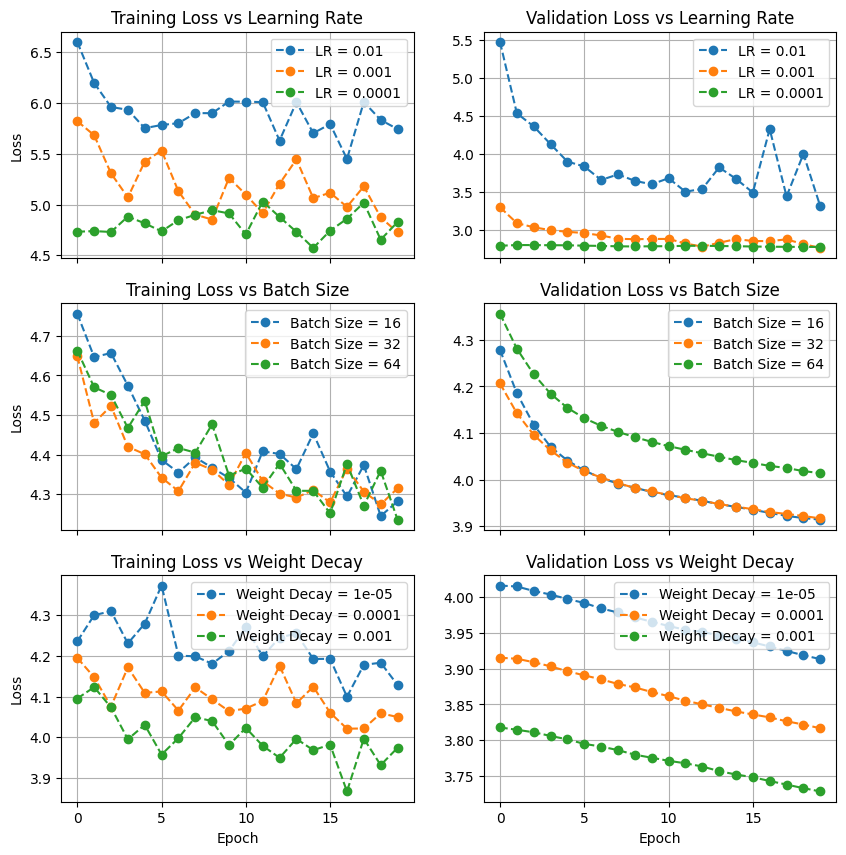

In [ ]:
fig, ax = plt.subplots(3,2, sharex=True, figsize=(10,10))
for lr in hyperparameters['LR']:
  ax[0,0].plot(train_losses['LR'][lr], label='LR = ' + str(lr), linestyle='dashed', marker='o')
  ax[0,1].plot(val_losses['LR'][lr], label='LR = ' + str(lr), linestyle='dashed', marker='o')


ax[0,0].set_title('Training Loss vs Learning Rate')
ax[0,0].set_ylabel('Loss')
ax[0,0].legend()
ax[0,0].grid()

ax[0,1].set_title('Validation Loss vs Learning Rate')
ax[0,1].legend()
ax[0,1].grid()

for batch_size in hyperparameters['BATCH_SIZE']:
  ax[1,0].plot(train_losses['BATCH_SIZE'][batch_size], label='Batch Size = ' + str(batch_size), linestyle='dashed', marker='o')
  ax[1,1].plot(val_losses['BATCH_SIZE'][batch_size], label='Batch Size = ' + str(batch_size), linestyle='dashed', marker='o')

ax[1,0].set_title('Training Loss vs Batch Size')
ax[1,0].set_ylabel('Loss')
ax[1,0].legend()
ax[1,0].grid()

ax[1,1].set_title('Validation Loss vs Batch Size')
ax[1,1].legend()
ax[1,1].grid()

for weight_decay in hyperparameters['WEIGHT_DECAY']:
  ax[2,0].plot(train_losses['WEIGHT_DECAY'][weight_decay], label='Weight Decay = ' + str(weight_decay), linestyle='dashed', marker='o')
  ax[2,1].plot(val_losses['WEIGHT_DECAY'][weight_decay], label='Weight Decay = ' + str(weight_decay), linestyle='dashed', marker='o')

ax[2,0].set_title('Training Loss vs Weight Decay')
ax[2,0].set_xlabel('Epoch')
ax[2,0].set_ylabel('Loss')
ax[2,0].legend()
ax[2,0].grid()

ax[2,1].set_title('Validation Loss vs Weight Decay')
ax[2,1].set_xlabel('Epoch')
ax[2,1].legend()
ax[2,1].grid()


fig.show()

#Training


In [12]:
train_iter = 0
val_iter = 0
min_accuracy = 0

trainSamples = len(train_dataset) - (len(train_dataset) % BATCH_SIZE)
val_samples = len(test_dataset)
iterPerEpoch = len(train_loader)
val_steps = len(val_loader)
cudnn.benchmark
model_checkpoint = "model" #name

train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    numCorrTrain = 0

    #blocks to train
    if homework_step > 0:
        model.lstm_cell.train(True)
    model.classifier.train(True)


    for i, (inputs, targets) in enumerate(train_loader):
        train_iter += 1
        optimizer_fn.zero_grad()

        # (BS, Frames, C, W, H) --> (Frames, BS, C, W, H)
        inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
        labelVariable = targets.to(DEVICE)

        # feeds in model
        output_label, _ = model(inputVariable)

        # compute loss
        loss = loss_fn(output_label, labelVariable)

        # backward loss and optimizer step
        loss.backward()
        optimizer_fn.step()

        #compute the training accuracy
        _, predicted = torch.max(output_label.data, 1)
        numCorrTrain += torch.sum(predicted == labelVariable.data).data.item()
        step_loss = loss.data.item()
        epoch_loss += step_loss

    avg_loss = epoch_loss/iterPerEpoch
    trainAccuracy = (numCorrTrain / trainSamples) * 100

    train_accuracies.append(trainAccuracy)
    train_losses.append(avg_loss)

    print(Fore.BLACK + 'Train: Epoch = {} | Loss = {:.3f} | Accuracy = {:.3f}'.format(epoch+1, avg_loss, trainAccuracy))
    if validate:
        if (epoch+1) % 1 == 0:
            model.train(False)
            val_loss_epoch = 0
            numCorr = 0
            for j, (inputs, targets) in enumerate(val_loader):
                val_iter += 1
                inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
                labelVariable = targets.to(DEVICE)

                 # feeds in model
                output_label, _ = model(inputVariable)
                val_loss = loss_fn(output_label, labelVariable)
                val_loss_step = val_loss.data.item()
                val_loss_epoch += val_loss_step
                _, predicted = torch.max(output_label.data, 1)
                numCorr += torch.sum(predicted == labelVariable.data).data.item()

            val_accuracy = (numCorr / val_samples) * 100
            avg_val_loss = val_loss_epoch / val_steps

            val_accuracies.append(val_accuracy)
            val_losses.append(avg_val_loss)

            print(Fore.GREEN + 'Val: Epoch = {} | Loss {:.3f} | Accuracy = {:.3f}'.format(epoch + 1, avg_val_loss, val_accuracy))
            if val_accuracy > min_accuracy:
                print("[||| NEW BEST on val||||]")
                save_path_model = os.path.join(model_folder, model_checkpoint)
                torch.save(model.state_dict(), save_path_model)
                min_accuracy = val_accuracy

    optim_scheduler.step()

print(Fore.CYAN + "Best Acc --> ", min_accuracy)
print(Fore.CYAN + "Last Acc --> ", val_accuracy)


Train: Epoch = 1 | Loss = 5.518 | Accuracy = 7.500
Val: Epoch = 1 | Loss 2.947 | Accuracy = 18.966
[||| NEW BEST on val||||]
Train: Epoch = 2 | Loss = 4.017 | Accuracy = 9.688
Val: Epoch = 2 | Loss 2.879 | Accuracy = 25.862
[||| NEW BEST on val||||]
Train: Epoch = 3 | Loss = 3.589 | Accuracy = 11.562
Val: Epoch = 3 | Loss 2.804 | Accuracy = 25.000
Train: Epoch = 4 | Loss = 3.370 | Accuracy = 15.313
Val: Epoch = 4 | Loss 2.709 | Accuracy = 23.276
Train: Epoch = 5 | Loss = 3.138 | Accuracy = 18.125
Val: Epoch = 5 | Loss 2.672 | Accuracy = 25.000
Train: Epoch = 6 | Loss = 2.947 | Accuracy = 23.438
Val: Epoch = 6 | Loss 2.629 | Accuracy = 31.034
[||| NEW BEST on val||||]
Train: Epoch = 7 | Loss = 2.991 | Accuracy = 20.312
Val: Epoch = 7 | Loss 2.573 | Accuracy = 27.586
Train: Epoch = 8 | Loss = 2.985 | Accuracy = 19.375
Val: Epoch = 8 | Loss 2.514 | Accuracy = 31.034
Train: Epoch = 9 | Loss = 2.815 | Accuracy = 24.062
Val: Epoch = 9 | Loss 2.549 | Accuracy = 29.310
Train: Epoch = 10 | Loss

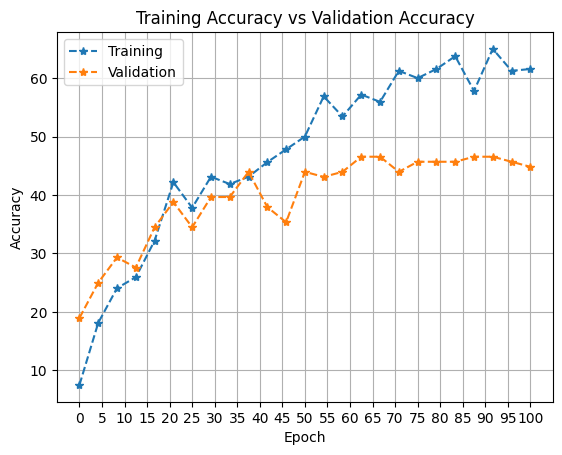

In [13]:

plt.plot( [x for i, x in enumerate(train_accuracies) if i%4 == 0] , label='Training', linestyle='dashed', marker='*')
plt.plot( [x for i, x in enumerate(val_accuracies) if i%4 == 0], label='Validation', linestyle='dashed', marker='*')
plt.xticks(np.linspace(0, 24, 21), range(0, 101, 5))
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

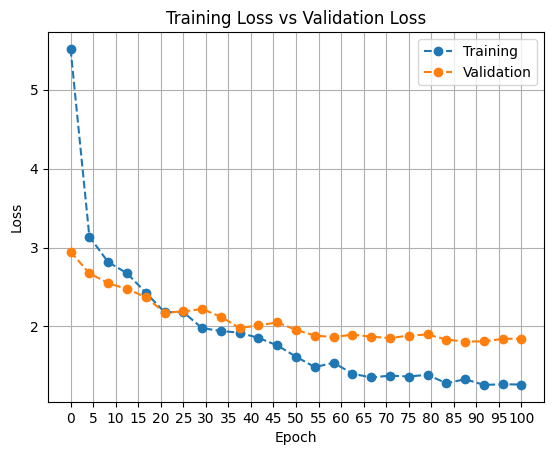

In [14]:
plt.plot( [x for i, x in enumerate(train_losses) if i%4 == 0] , label='Training', linestyle='dashed', marker='o')
plt.plot( [x for i, x in enumerate(val_losses) if i%4 == 0], label='Validation', linestyle='dashed', marker='o')
plt.xticks(np.linspace(0, 24, 21), range(0, 101, 5))
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#Test

In [15]:
model.train(False)
val_loss_epoch = 0
numCorr = 0
val_iter = 0
val_samples = len(test_dataset)
val_steps = len(val_loader)

with torch.no_grad():
    for j, (inputs, targets) in enumerate(val_loader):
        val_iter += 1
        inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
        labelVariable = targets.to(DEVICE)

        output_label, _ = model(inputVariable)
        val_loss = loss_fn(output_label, labelVariable)
        val_loss_step = val_loss.data.item()
        val_loss_epoch += val_loss_step
        _, predicted = torch.max(output_label.data, 1)
        numCorr += torch.sum(predicted == labelVariable.data).data.item()

    val_accuracy = (numCorr / val_samples) * 100
    avg_val_loss = val_loss_epoch / val_steps

print('Loss {:.3f} | Accuracy = {:.3f}%'.format(avg_val_loss, val_accuracy))

Loss 1.825 | Accuracy = 43.966%


# Class Activation Maps (CAM)

In [16]:
#Class Activation Map (CAM)
def CAM(model, weights, inputVariable):

  cam_results=[]


  for t in range(inputVariable.size(0)):


        logits, feature_conv, _ = model(inputVariable[t])

        batch_size, number_channels, h, w = feature_conv.size()


        feature_conv_1 = feature_conv.view(batch_size, number_channels, h * w)


        probabilities, indexes = logits.sort(dim=1, descending=True)

        class_indexes = indexes[:, 0]

        softmax_weights = weights[class_indexes].unsqueeze(1)



        cam = torch.bmm(softmax_weights, feature_conv_1)

        for i in range(cam.shape[0]):
          cam_img = F.softmax(cam[i],1).data

          cam_img = cam_img.cpu().numpy()


          cam_img = cam_img.reshape(h, w)

          cam_img = cam_img - np.min(cam_img)
          cam_img = cam_img / np.max(cam_img)
          cam_img = np.uint8(255 * cam_img)

          output_cam = cv2.resize(cam_img, (256,256), interpolation=cv2.INTER_LINEAR)

          input = inputVariable[t][i].unsqueeze(0)
          input = F.interpolate(input, size=(256, 256), mode='bilinear', align_corners=False)
          input = input.squeeze(0).permute(1, 2, 0)


          img = cv2.cvtColor(np.uint8(input.cpu()), cv2.COLOR_RGB2BGR)


          heatmap  = cv2.applyColorMap(output_cam, cv2.COLORMAP_JET)

          result = 0.5 * img + 0.3 * heatmap

          cam_results.append(result)

        return cam_results




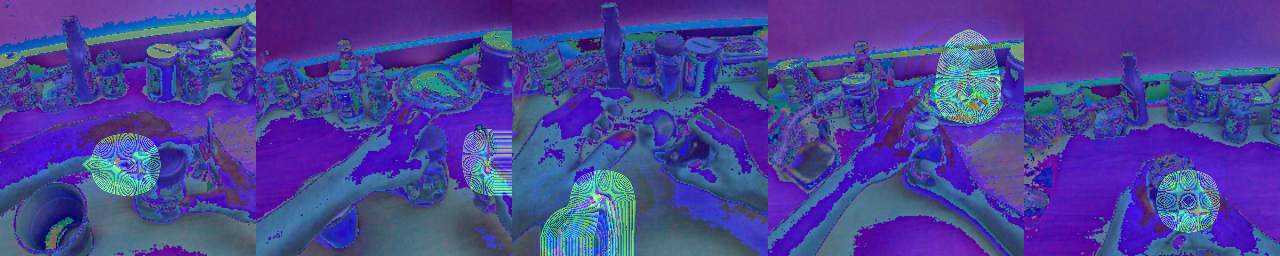

In [92]:
final_results = []
blended_images = []
flattened = []
dataset = val_loader.dataset
num_random_images = 5
idx = np.random.choice(len(dataset), size=1, replace=False)


# Loop through the validation dataset and get the CAM results
for i, (inputs, targets) in enumerate(val_loader):
    inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
    targets = targets.to(DEVICE)

    # Assuming `CAM` is a function that processes the image and returns a CAM image
    results = CAM(model.resNet, model.weight_softmax, inputVariable)
    final_results.append(results)

# Flatten the list of results (assuming CAM returns images in a list or tensor format)
flattened = list(chain.from_iterable(final_results))

for i in range(num_random_images):

    # Get the original image and corresponding CAM image
    original_image = dataset[idx[0] + i][0]  # Original image (PyTorch tensor)

    # If the original image is in the shape [batch_size, channels, height, width], extract one image
    original_image = original_image[0]  # Select the first image from the batch
    original_image = original_image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format (height, width, channels)

    cam_image = flattened[idx[0] + i]

    # Ensure image is in the correct range [0, 255] for OpenCV
    original_image = (original_image * 255).astype(np.uint8)


    # Resize both images to the same size (e.g., 256x256)
    original_image_resized = cv2.resize(original_image, (256, 256))
    cam_image_resized = cv2.resize(cam_image, (256, 256))

    cam_image_resized = (cam_image_resized * 255).astype(np.uint8)  # Normalize and convert to uint8

    # Normalize CAM image to [0, 255] for display
    cam_image_resized = cv2.applyColorMap(cam_image_resized, cv2.COLORMAP_JET)

    # Blend the original image with the CAM image
    alpha = 0.5  # Alpha transparency for overlay
    blended_image = cv2.addWeighted(original_image_resized, 1 - alpha, cam_image_resized, alpha, 0)

    # Append the blended image to the list
    blended_images.append(blended_image)

# Concatenate the 5 blended images side by side
concatenated_images = np.hstack(blended_images)

# Display the concatenated image
cv2_imshow(concatenated_images)

